# Predição da cotação do Bitcoin usando redes LSTM

## Membros

* Gabriel Pessoa
* Ícaro Guerra
* Lucas Barros
* Matheus Pessoa
* Rafael Mota

## Introdução
Esse relatório detalha o processo experimental do desenvolvimento de um solução para predição da cotação do Bitcoin baseado em seus valores anteriores usando redes neurais recoorrentes do tipo LSTM. O dataset consiste em 1272 registros dos valores de fechamento da cotação do Bitcoin de dezembro de 2014 a maio de 2018. Usaremos os primeiros 80% dos registros para treinamento e os 20% restantes para teste.

## Bibliotecas Utilizadas

Usaremos a seguintes bibliotecas para a experimentação:

In [194]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

* O Numpy e o Pandas são usados para a representação dos dados e para a implementação de funções auxiliares.

* Tensorflow e Keras são usados para a implementação e treinamento das Redes Neurais.

* Sklearn será utilizado para o pré processamento dos dados.

* Matplotlib será utilizado para visualização dos dados e dos resultados.

### Parâmetros de treinamento

Usaremos os seguintes parâmetros para todos os treinamentos realizados:


In [195]:
train_ratio = 0.8
max_epochs = 50
verbose= 0
batch_size=5

## Carregamento dos Dados

Em seguida, carregamos os dados em DataFrame, e extraimos os valor da cotação em seu fechamento em cada uma das datas, ajustamos também o dataset para que ele fique ordenado de acordo com a data do registro, para que possamos treinar dar dados mais antigos para prever dados futuros.

In [196]:
data = pd.read_csv("./btc.csv").sort_index(ascending=False)

data.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
1272,12/1/2014,BTCUSD,300.0,370.0,300.00,370.0,0.05656,19.53
1271,12/2/2014,BTCUSD,370.0,378.0,370.00,378.0,15.01000,5675.07
1270,12/3/2014,BTCUSD,378.0,378.0,377.01,378.0,0.54660,206.52
1269,12/4/2014,BTCUSD,378.0,378.0,377.10,377.1,0.01000,3.77
1268,12/5/2014,BTCUSD,377.1,377.1,377.10,377.1,0.00000,0.00


In [197]:
prices = data["Close"].values

prices

array([ 370.  ,  378.  ,  378.  , ..., 7584.15, 7459.11, 7520.  ])

Como redes LSTM trabalham melhor com a escala dos dados, aplicamos um pré-processamento que extrai a escala do valor de cada um registros, em seguida plotamos um gráficos para que possamos visualizar a natureza do dataset utilizado.

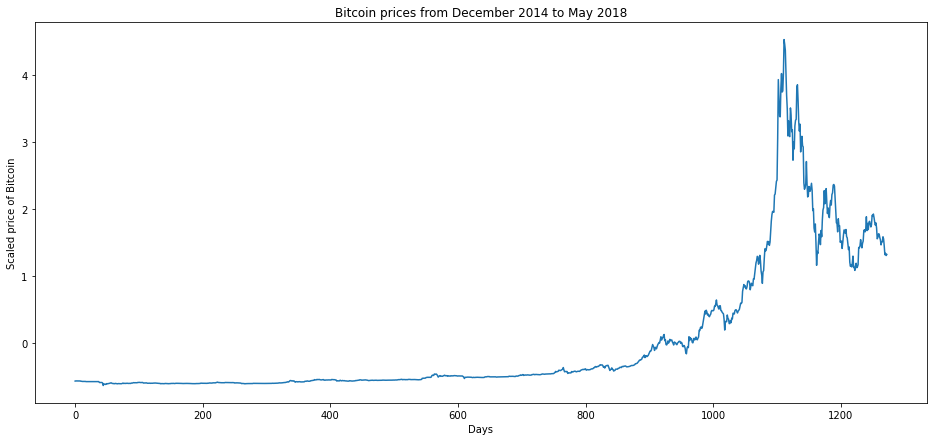

In [198]:
scaler = StandardScaler()

scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

plt.figure(figsize=(16, 7))
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_prices, label='Price')
plt.show()


Aqui definimos a funções auxiliares que usaremos no processo experimental, cada uma delas desempenha uma função no processo experimental:

* A função `window_data` gera o nosso dataset baseado na série histórica, ela recebe um parâmetro window_size, que determina quantos dias anteriores serão utilizados para realizar a predição.
* A função `split_train_test` tem a função de separar o dataset gerado na função `window_data`, em datasets de treinamento e de teste, respeitando a proporção definida anteriormente.
* A função `plot_result` gera um gráfico com as predições do modelo para o conjunto de teste passado, ela será para análisar os resultados obtidos.

In [199]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return np.array(X), np.array(y)

def split_train_test(x, y):
    train_size = int(len(x) * train_ratio)

    def reshape(data):
        return np.reshape(data, (data.shape[0], 1, data.shape[1]))

    x_train = reshape(x[:train_size])
    y_train = reshape(y[:train_size])

    x_test = reshape(x[train_size:])
    y_test = reshape(y[train_size:])

    return x_train, y_train, x_test, y_test

def plot_result(model, x_train, x_test):
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)

    test_results = ([None] * len(y_train_pred)) + list(y_test_pred)

    #we now plot predictions from the network
    plt.figure(figsize=(16, 7))
    plt.title('Bitcoin prices from December 2014 to May 2018')
    plt.xlabel('Days')
    plt.ylabel('Scaled Price of Bitcoin')
    plt.plot(scaled_prices, label='Original data')
    plt.plot(y_train_pred, label='Training data')
    plt.plot(test_results, label='Testing data')
    plt.legend()
    plt.show()

## Experimentação

Em seguida, vamos avaliar a perfomance das redes LSTM com diversos parâmetros a fim encontrar um solução ótima.

### LSTM 1

Primeiramente vamos gerar o dataset inicial com um janela de aprendizado pequena e uma rede simples para estabelecer um base de perfomance.

In [200]:
window_size = 3

x, y = window_data(scaled_prices, window_size)
x_train, y_train, x_test, y_test = split_train_test(x, y)

In [201]:
model = keras.Sequential([
    layers.LSTM(50,input_shape=(1, window_size)),
    layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 50)                10800     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 10,851
Trainable params: 10,851
Non-trainable params: 0
_________________________________________________________________


In [202]:
model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

Pelo gráficos, podemos perceber que as predições se assemelham bastante no começo do dataset de teste, mas a medida que vamos se afastando dos dados de treinamento a curva passa a não acompanhar, isso pode indicar que nossa rede está perdendo muita informação a medida que se afasta do conjunto de treinamento.

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


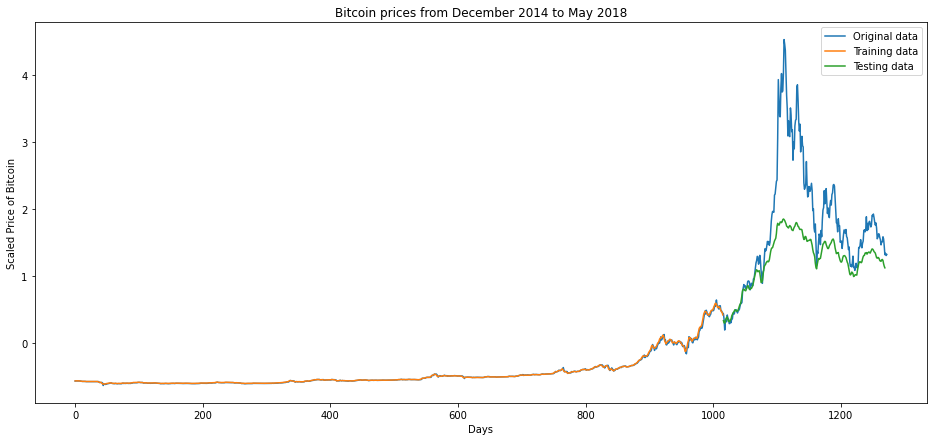

In [203]:
plot_result(model, x_train, x_test)

Percebemos também que a taxa de perda foi bem alta.

In [204]:
model.evaluate(x_test, y_test)

8/8 [==============================] - 1s 3ms/step - loss: 0.6343


0.6342508792877197

### LSTM 2

Em seguida experimentamos aumentar a quantidade de nós na camada LSTM:

In [205]:
model1 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size)),
    layers.Dense(1)
])

model1.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model1.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 400)               646400    
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 401       
Total params: 646,801
Trainable params: 646,801
Non-trainable params: 0
_________________________________________________________________


In [206]:
model1.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

Com o valor de 400 nós na camada de LSTM, o tempo de treinamento aumentou considerávelmente, mas como pode ser visto, conseguimos aproximar bem melhor a curva nos dados de teste. Isso pode indicar que redes LSTM com mais nós tem uma capacidade maior de prever dados futuros.

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


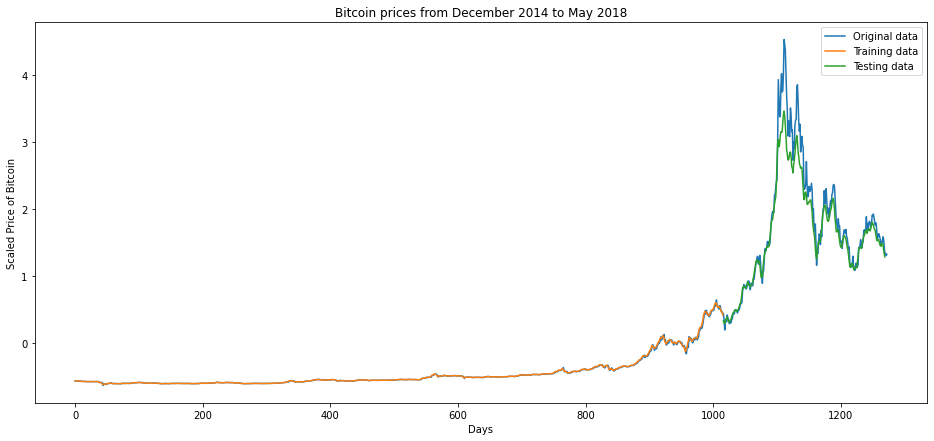

In [207]:
plot_result(model1, x_train, x_test)

Percebemos também que a taxa de perda diminiu bastante.

In [208]:
model1.evaluate(x_test, y_test)

8/8 [==============================] - 1s 4ms/step - loss: 0.0929


0.09288912266492844

### LSTM 3

Em seguida, tentamos aumentar a janela de aprendizado:


In [234]:
window_size = 7

x, y = window_data(scaled_prices, window_size)
x_train, y_train, x_test, y_test = split_train_test(x, y)

In [235]:
model2 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size)),
    layers.Dense(1)
])

model2.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model2.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 400)               652800    
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 401       
Total params: 653,201
Trainable params: 653,201
Non-trainable params: 0
_________________________________________________________________


In [236]:
model2.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


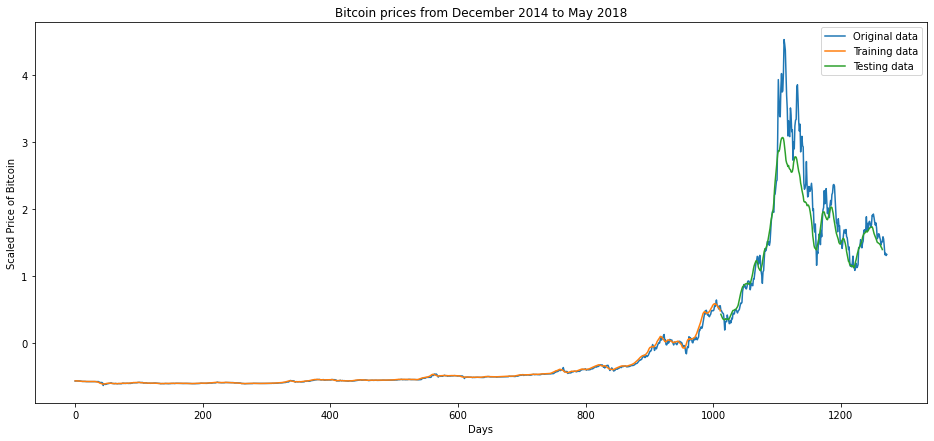

In [238]:
plot_result(model2, x_train, x_test)

In [240]:
model2.evaluate(x_test, y_test)

8/8 [==============================] - 1s 5ms/step - loss: 0.1583


0.15832988917827606

### LSTM 4

Em seguida, tentamos também reduzir a janela de aprendizado:


In [242]:
window_size = 2

x, y = window_data(scaled_prices, window_size)
x_train, y_train, x_test, y_test = split_train_test(x, y)

In [243]:
model3 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size)),
    layers.Dense(1)
])

model3.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model3.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 400)               644800    
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 401       
Total params: 645,201
Trainable params: 645,201
Non-trainable params: 0
_________________________________________________________________


In [244]:
model3.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

Reduzindo a janela de aprendizado, obtemos uma pequena melhora no resultado:

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


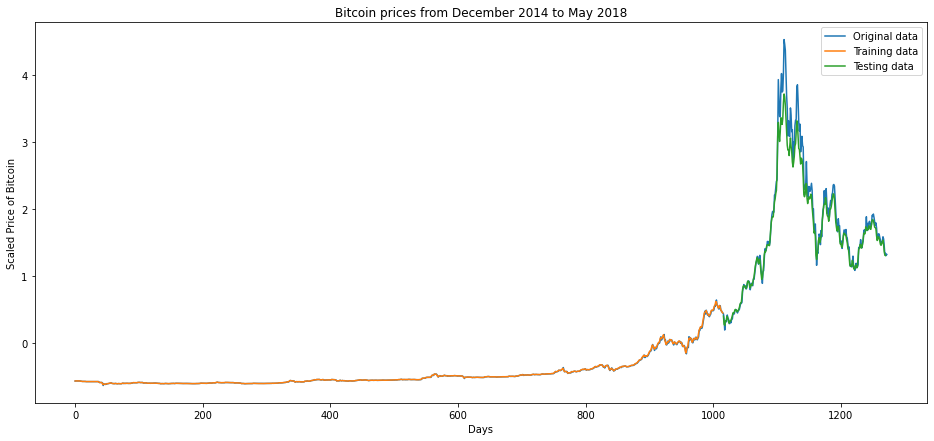

In [246]:
plot_result(model3, x_train, x_test)

A perda também reduziu um pouco.

In [247]:
model3.evaluate(x_test, y_test)

8/8 [==============================] - 2s 7ms/step - loss: 0.0603


0.06029904633760452

### LSTM 5

Experimentamos também adicionar dropout:

In [255]:
model4 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size), dropout=0.1),
    layers.Dense(1)
])

model4.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model4.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 400)               644800    
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 401       
Total params: 645,201
Trainable params: 645,201
Non-trainable params: 0
_________________________________________________________________


In [256]:
model4.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

Nesse caso, adicionar dropout piorou o nosso desempenho.

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


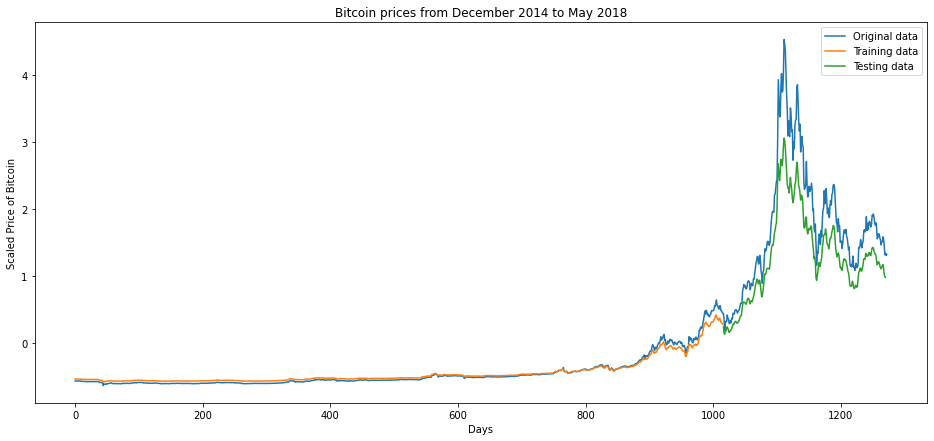

In [257]:
plot_result(model4, x_train, x_test)

In [260]:
model4.evaluate(x_test, y_test)

8/8 [==============================] - 1s 6ms/step - loss: 0.3234


0.32339632511138916

### LSTM 6

Experimentamos também variar a função da ativação:

In [261]:
model5 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size), activation="relu"),
    layers.Dense(1)
])

model5.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model5.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 400)               644800    
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 401       
Total params: 645,201
Trainable params: 645,201
Non-trainable params: 0
_________________________________________________________________


In [262]:
model5.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size, verbose=verbose)

Também tivemos um perda de desempenho.

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


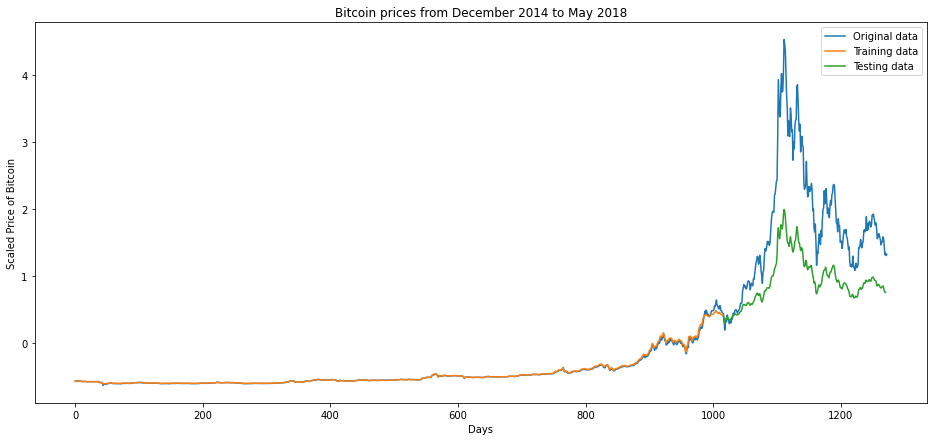

In [264]:
plot_result(model5, x_train, x_test)

In [263]:
model5.evaluate(x_test, y_test)

8/8 [==============================] - 0s 3ms/step - loss: 1.0324


1.032387614250183

In [265]:
window_size = 2

x, y = window_data(scaled_prices, window_size)
x_train, y_train, x_test, y_test = split_train_test(x, y)

### LSTM 7

Testamos também usar a técnica de Early Stopping, que para o treinamento quando a métrica de loss piora por 10 épocas de treinamos seguidas:

In [266]:
model6 = keras.Sequential([
    layers.LSTM(400, input_shape=(1, window_size)),
    layers.Dense(1)
])

model6.compile(loss="mean_squared_error", optimizer="sgd", metrics=metrics)

model6.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 400)               644800    
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 401       
Total params: 645,201
Trainable params: 645,201
Non-trainable params: 0
_________________________________________________________________


In [267]:
model6.fit(x_train, y_train, epochs=100000, batch_size=batch_size, verbose=verbose, callbacks=[EarlyStopping(monitor="loss",patience=10)])

Utilizando essa técnica tivemos uma melhora na curva.

/home/rafaelmota/miniconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


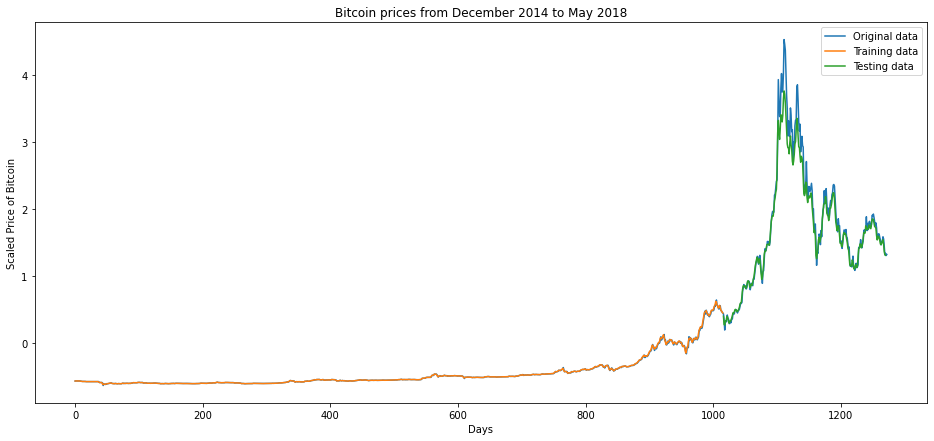

In [268]:
plot_result(model6, x_train, x_test)

In [270]:
model6.evaluate(x_test, y_test)

8/8 [==============================] - 0s 4ms/step - loss: 0.0548


0.05482427403330803